In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from alibi.prototypes import ProtoSelect
from alibi.prototypes.protoselect import cv_protoselect_euclidean, visualize_prototypes
from alibi.utils.kernel import EuclideanDistance
from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2

/home/robert/anaconda3/envs/alibi/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load MNIST dataset

In [2]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()
X_train, X_test = X_train / 255., X_test / 255.

# get validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=1000, random_state=0)

# select random samples from train an test
size = 1000
train_idx = np.random.choice(len(X_train), size=size, replace=False)
test_idx = np.random.choice(len(X_test), size=size, replace=False)
X_train, Y_train = X_train[train_idx], Y_train[train_idx]
X_test, Y_test = X_test[test_idx], Y_test[test_idx]

# define preprocessing function
preprocess_fn = lambda x: x.reshape(len(x), -1)

In [4]:
num_prototypes = 20
grid_size = 50
quantiles = (0.1, 0.9)

# get best eps by cv
eps = cv_protoselect_euclidean(refset=(X_train, Y_train),
                               protoset=(X_test,),
                               valset=(X_val, Y_val),
                               num_splits=5,
                               num_prototypes=num_prototypes,
                               quantiles=quantiles,
                               grid_size=grid_size,
                               preprocess_fn=preprocess_fn)

In [5]:
explainer = ProtoSelect(kernel_distance=EuclideanDistance(), eps=eps)
explainer = explainer.fit(X=X_train, X_labels=Y_train, Y=X_test)

In [6]:
explanation = explainer.explain(num_prototypes=num_prototypes)

In [9]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn = knn.fit(X=preprocess_fn(explanation.data['prototypes']), y=explanation.data['prototypes_labels'])
knn.score(preprocess_fn(X_test), Y_test)

0.742

In [10]:
import umap
reducer = umap.UMAP()
reducer = reducer.fit(preprocess_fn(X_train))

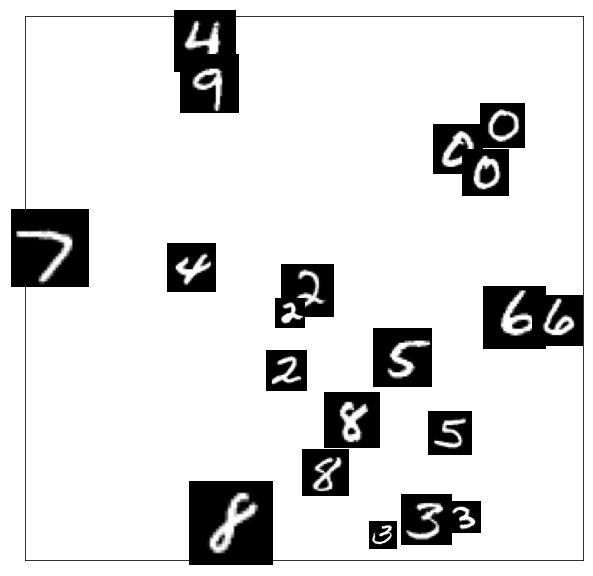

In [11]:
visualize_prototypes(explanation=explanation,
                     refset=(X_train, Y_train),
                     reducer=reducer.transform,
                     preprocess_fn=preprocess_fn)